This file presents the results obtained for artificial datasets.

In [26]:
from __init__ import *
from keras.models import load_model
% matplotlib inline

In [31]:
def safe2str(x):
    if type(x) == str:
        return x
    if type(x) == dict:
        return '%d+%d' % (x['sigs'], x['offs'])
    return str(int(x))

def get_pivot(setting, df, valcols=[]):
    if setting['objective'] == 'class':
        best = 'best_acc'
        func = max
    else:
        best = 'best_mse'
        func = min
    df0 = df.copy()
    for k, v in setting.items():
        df0 = df0[df0[k] == v]
    df0 = df0[df0.groupby(['data', 'model'])[best].transform(func) == df0[best]]
    pivs = [df0.pivot(index='data', columns='model', values=best)]
    for col in valcols:
        piv = df0.pivot(index='data', columns='model', values=col)
        piv.rename(columns=dict([(c, col[:3] + '_' + c) for c in piv.columns]), inplace=True)
        pivs.append(piv.copy())
    return df0, pd.concat(pivs, axis=1)

def get_df_for_key(key, data):
    df = dfbest[dfbest['data'] == data].copy()
    df = df[df.groupby(['specialkey', 'data'])['best_mse'].transform(min) == df['best_mse']]
    dfs = []
    for model, gbkey in zip(['cvi2', 'cnn', 'lstm'], [key, 'filters', 'layer_size']):
        df0 = df[df['model'] == model]
    #     if model == 'lstm'
        df0 = df0[df0.groupby(gbkey)['best_mse'].transform(min) == df0['best_mse']].copy()
        df0['specialkey'] = df0[gbkey].apply(lambda x: model + ' ' + str(x))
        dfs.append(df0)
    df = pd.concat(dfs)
    return df

Reading the results from the results files. 
all_results -> results from grid search
best_results -> results from re-running (5 times) the best model settings for each model and dataset

In [32]:
all_results = pd.read_pickle(WDIR + '/results/cluster_results.pkl')

key = 'best_model_test'
mindate = '2017-02-13'
files = [f for f in os.listdir('results') if (key in f) and ('.pkl' in f)]

read_tables = []

for f in files:
    try:
        df = pd.read_pickle(WDIR + '/results/' + f)
        df = df[df['dt'] > pd.Timestamp(mindate)]
        df['epochs'] = df['loss'].apply(lambda x: len(x))
        df = df[df['epochs'] > 5]
        if df.shape[0] == 0:
            continue
        if 'objective' not in df.columns:
            df['objective'] = 'regr'
        if 'returns' not in df.columns:
            df['returns'] = ('ret' in f)
        elif 'both' in f:
            df = df[df['returns']] ###### screwed up classification loss in 'both'
        if 'full_shift' not in df.columns:
            df['full_shift'] = True
        df['NeX'] = ('NeX' in f)
        if 'batch_size' not in df.columns:
            df['batch_size'] = 64
        if 'channels' not in df.columns:
            if 'filters' in df.columns:
                df['channels'] = df['filters']
            else:
                df['channels'] = 1
        else:
            df.loc[np.isnan(df['channels']), 'channels'] = 1
        ### 'CVI', CNN' 'LSTM' specific -- GETTING RIGHT MODEL 
        df = df[~np.isnan(df['batch_size'])]
        df['model'] = np.nan
        if 'layer_size' in df.columns:
            df.loc[~np.isnan(df['layer_size']), 'model'] = 'lstm'
        if 'layers_no' in df.columns:
            ind = np.isnan(df['model'])
            df.loc[ind, 'model'] = df.loc[ind, 'layers_no'].apply(lambda x: 'cvi2' if (type(x) == dict) else 'cnn') 
        keys, funcs, names = [], [], []
        df['best_mse'] = np.nan
        df['best_epoch'] = np.nan
        if 'val_main_output_loss' in df.columns:
            ind = df['val_main_output_loss'].apply(lambda x: type(x) == list)
            df.loc[ind, 'best_mse'] = df.loc[ind, 'val_main_output_loss'].apply(lambda x: np.nanmin([np.inf] + x))
            df.loc[ind, 'best_epoch'] = df.loc[ind, 'val_main_output_loss'].apply(lambda x: np.nanargmin([np.inf] + x))
        ind = np.isnan(df['best_mse'])
        df.loc[ind, 'best_mse'] = df.loc[ind, 'val_loss'].apply(lambda x: np.nanmin([np.inf] + x))
        df.loc[ind, 'best_epoch'] = df.loc[ind, 'val_loss'].apply(lambda x: np.nanargmin([np.inf] + x))        
        df['time_per_epoch'] = df['training_time'] / df['epochs']
        df['time_to_best'] = df['best_epoch'] * df['time_per_epoch']
        # SPECIALKEY
        df['strlayers_no'] = df['layers_no'].apply(safe2str)
        df['specialkey'] = np.nan
        for model, gbkey in zip(['cvi2', 'cnn', 'lstm'], ['strlayers_no', 'filters', 'layer_size']):
            if gbkey in df.columns:
                ind = (df['model'] == model)
                df.loc[ind, 'specialkey'] = df.loc[ind, gbkey].apply(lambda x: model + ' ' + safe2str(x))
        read_tables.append(df.copy())
    except Exception as e:
        raise(e)

best_results = pd.concat(read_tables)  

Obtaining table with all results with selected best hyperparameter settings. -> dfbest

In [33]:
key = 'layers_no'
df = all_results.copy()
dfs = []

df['str' + key] = df[key].apply(safe2str)    

for model, gbkey in zip(['cvi2', 'cnn', 'lstm'], ['str' + key, 'filters', 'layer_size']):
    df0 = df[df['model'] == model]
    df0 = df0[df0.groupby([gbkey, 'data'])['best_mse'].transform(min) == df0['best_mse']].copy()
    df0['specialkey'] = df0[gbkey].apply(lambda x: model + ' ' + safe2str(x))
    dfs.append(df0)
df = pd.concat(dfs)
df = df[~df['specialkey'].isin(['lstm 8', "cvi2 1+1"])]
df = df[df['data'].apply(lambda x: '50000' not in x)]
dfbest0 = df
dfbest = pd.concat([df, best_results])
dfbest = dfbest[~dfbest['specialkey'].isin(['lstm 8', 'lstm 16', "cvi2 1+1"])]

Plotting results for 2 sample datasets and selected CNN and proposed SOCNN model.

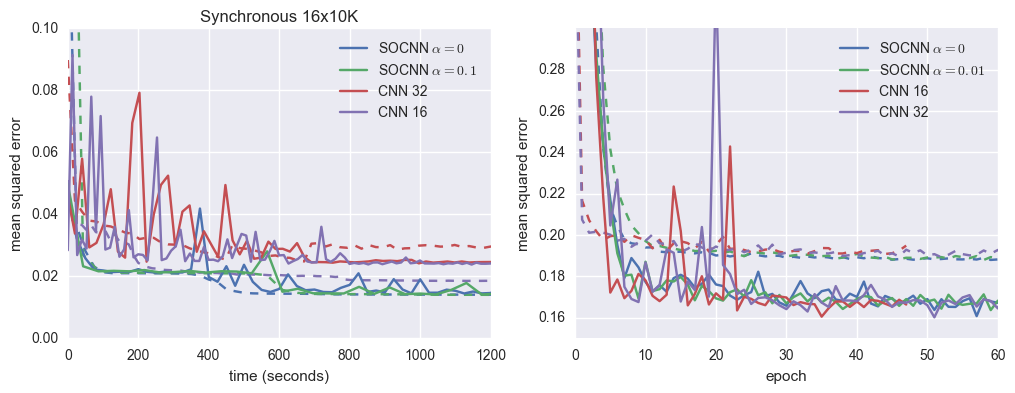

In [34]:
fig, axes  = plt.subplots(1, 2, figsize=(12,4))
special_dict = {
    'cvi2 0.0': "SOCNN $\\alpha=0$",
    'cvi2 0.1': "SOCNN $\\alpha=0.1$",
    'cvi2 0.01': "SOCNN $\\alpha=0.01$",
    'cnn 32.0': 'CNN 32',
    'cnn 16.0': 'CNN 16',
    'lstm 32.0': 'LSTM 32',
    'lstm 64.0': 'LSTM 64'
}
key = 'aux_weight'
data = 'data/artificialET1SS1n100000S16.csv'
df = get_df_for_key(key, data)
colors = sns.color_palette()
ci = 0
for prefix in ['', 'val_']:
    for model, val2, val, t, label in zip(df['model'], df[prefix + 'loss'], df[prefix + 'main_output_loss'], df['training_time'], df['specialkey']):
        if label in ['cvi2 0.01', 'lstm 32.0', 'lstm 64.0']:
            continue
        if (type(val) != list):
            if np.isnan(val):
                val = val2
        nn = float(len(val))
    #     axes[0].plot(np.arange(nn), val, label=special_dict[label])
        if prefix =='val_':
            axes[0].plot(np.arange(nn)*t/nn, val, label=special_dict[label], color=colors[ci])
        else:
            axes[0].plot(np.arange(nn)*t/nn, val, ls='--', color=colors[ci])
        ci = (ci + 1) % 4
data = 'data/artificialET1SS0n10000S16.csv'
df = get_df_for_key(key, data)    
for prefix in ['', 'val_']:
    for model, val2, val, t, label in zip(df['model'], df[prefix + 'loss'], df[prefix + 'main_output_loss'], df['training_time'], df['specialkey']):
        if label in ['cvi2 0.1', 'lstm 32.0', 'lstm 64.0']:
            continue
        if (type(val) != list):
            if np.isnan(val):
                val = val2
        nn = float(len(val))
    #     axes[0].plot(np.arange(nn), val, label=special_dict[label])
        if prefix =='val_':
            axes[1].plot(np.arange(nn), val, label=special_dict[label], color=colors[ci])
        else:
            axes[1].plot(np.arange(nn), val, ls='--', color=colors[ci])
        ci = (ci + 1) % 4
#     axes[1].plot(np.arange(nn), val, label=special_dict[label])    
#     axes[1].plot(np.arange(nn)*t/nn, val, label=special_dict[label])

for ax in axes:
    ax.legend()    
    ax.set_ylabel('mean squared error')
axes[0].set_xlim((0,1200))
axes[1].set_xlim((0, 60))
axes[1].set_xlabel('epoch')
axes[0].set_xlabel('time (seconds)')
axes[0].set_ylim((0., .1))
axes[1].set_ylim((0.15, .3))
axes[0].set_title('Asynchronous 16x100K')
axes[0].set_title('Synchronous 16x10K')
fig.savefig(WDIR + '/results/val_error.pdf', bbox_inches='tight')

Table with best results for each dataset and the model

In [16]:
pd.options.display.float_format = '{:,.4f}'.format
toplot = dfbest.groupby(['specialkey', 'data'])['layers_no', 'best_mse'].min().reset_index()
toplot['best_mse'].apply(lambda x: x if (x < 1) else 100)
piv = toplot.pivot(index='specialkey', columns='data', values='best_mse')
piv = piv.rename(columns=lambda x: x[-6:-4] + 'x' + x[22:-10] + 'K type' + x[20:21])
print(piv.to_latex())


\begin{tabular}{lrrrrrrrr}
\toprule
data &  16x100K type0 &  64x100K type0 &  16x10K type0 &  64x10K type0 &  16x100K type1 &    64x100K type1 &  16x10K type1 &  64x10K type1 \\
specialkey &                &                &               &               &                &                  &               &               \\
\midrule
cnn 16     &         0.1830 &         0.0495 &        0.1605 &        0.0447 &         0.0238 &           0.0177 &        0.0403 &        0.0451 \\
cnn 32     &         0.1832 &         0.0496 &        0.1602 &        0.0445 &         0.0242 &           0.0179 &        0.0395 &        0.0396 \\
cvi2 10+1  &         0.1838 &         0.0498 &        0.1604 &        0.0456 &         0.0139 &           0.0165 &        0.0167 &        0.0255 \\
cvi2 10+10 &         0.1863 &         0.0506 &        0.1629 &        0.0493 &         0.0139 &           0.0166 &        0.0184 &        0.0227 \\
cvi2 10+2  &         0.1830 &         0.0498 &        0.1608 &        0.0

Some additional tables for the paper.

In [35]:
best_per_data = dfbest.groupby('data')['best_mse'].min()
df2 = dfbest.copy()
df2['discard'] = False
for data, v in best_per_data.items():
    df2.loc[df2['data'] == data, 'best_mse'] /= v
    df2.loc[(df2['data'] == data) & (df2['best_mse'] > 5), 'discard'] = True
df2 = df2[~df2['discard']]
df2['data_type'] = df2['data'].apply(lambda x: 'Synchronous' if ('SS0' in x) else 'Asynchronous')
df2['specialkey2'] = df2['model'] + df2['aux_weight'].apply(str)

Relative errors for different auxillary loss weight

In [36]:
pd.options.display.float_format = '{:,.2f}%'.format
piv2 = df2.groupby(['specialkey2', 'data_type'])['best_mse'].mean().reset_index()
piv2['best_mse'] *= 100
piv2 = piv2.pivot(index='specialkey2', columns='data_type', values='best_mse')
print(piv2[piv2.columns[::-1]].to_latex())

\begin{tabular}{lrr}
\toprule
data\_type &  Synchronous &  Asynchronous \\
specialkey2 &              &               \\
\midrule
cnnnan      &      101.47\% &       243.14\% \\
cvi20.0     &      101.80\% &       160.21\% \\
cvi20.01    &      105.78\% &       120.40\% \\
cvi20.1     &      109.63\% &       119.89\% \\
lstmnan     &      135.74\% &       345.63\% \\
\bottomrule
\end{tabular}



In [37]:
dfbest0['data_type'] = dfbest0['data'].apply(lambda x: 'Synchronous' if ('SS0' in x) else 'Asynchronous')
dfbest0.groupby(['data_type', 'aux_weight'])['data_type'].count()

data_type     aux_weight
Asynchronous  0.00%         4
              0.01%         3
              0.10%         9
Synchronous   0.00%         5
              0.01%         8
              0.10%         3
Name: data_type, dtype: int64

In [38]:
def f_arch(x):
    if type(x) == dict:
        if x['softmax']:
            return 'softmax'
        else:
            return 'softplus'
    return None
dfbest0['strarchitecture'] = dfbest0['architecture'].apply(f_arch)
dfbest0.groupby(['data_type', 'strarchitecture'])['data_type'].count()

data_type     strarchitecture
Asynchronous  softmax            11
              softplus            5
Synchronous   softmax            10
              softplus            6
Name: data_type, dtype: int64